In [26]:
import sys
sys.path.append("..")

import json
import numpy as np

In [27]:
def get_results(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    #print("Number of data points: ", len(data))
    return data

In [28]:
def get_test_data_annotations():
    visual_news_data = json.load(open("../../datasets/visualnews/origin/data.json"))
    visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}

    test_data = json.load(open("../../news_clippings/news_clippings/data/merged_balanced/test.json"))
    annotations = test_data["annotations"]
    return annotations
test_data_annotations = get_test_data_annotations()

In [29]:
def fix_unsures(data):
    """
    In instances where one of the models does not have any output, consider the output of the other model to be the truth
    """
    num_unsures = 0
    for i in range(len(data)):
        if data[i]['falsified'] == "Unsure":
            num_unsures += 1
            if data[i]['output']['model_0'] == "" and data[i]['output']['model_1'] != "":
                if "YES" in data[i]['output']['model_1']:
                    data[i]['falsified'] = True
                elif "NO" in data[i]['output']['model_1']:
                    data[i]['falsified'] = False
            elif data[i]['output']['model_0'] != "" and data[i]['output']['model_1'] == "":
                if "YES" in data[i]['output']['model_0']:
                    data[i]['falsified'] = True
                elif "NO" in data[i]['output']['model_0']:
                    data[i]['falsified'] = False
    print("Num unsures: ", num_unsures)
    return data

In [30]:
def num_disagreements(data):
    """
    Function to check when models actually disagree and when they are just unsure
    """
    disagreements = 0
    for i in range(len(data)):
        m0 = data[i]['output']['model_0']
        m1 = data[i]['output']['model_1']
        if data[i]['falsified'] == "Unsure":
            #check if models disagree
            if "YES" in m0 and ("NO" in m1 or "UNSURE" in m1):
                disagreements += 1
            elif "NO" in m0 and ("YES" in m1 or "UNSURE" in m1):
                disagreements += 1
            elif "UNSURE" in m0 and ("YES" in m1 or "NO" in m1):
                disagreements += 1
    print("Num disagreements: ", disagreements)

In [31]:
def get_accuracy(data, annotations):
    num_correct = 0
    data = fix_unsures(data)
    incorrect_idx = []
    for i in range(len(data)):
        if bool(data[i]['falsified']) == annotations[i]['falsified']:
            num_correct += 1
        else:
            incorrect_idx.append(i)
    return num_correct/len(data)

In [32]:
def get_incorrect_idx(data, annotations):
    num_correct = 0
    data = fix_unsures(data)
    incorrect_idx = []
    for i in range(len(data)):
        if bool(data[i]['falsified']) != annotations[i]['falsified']:
            incorrect_idx.append(i)
    return incorrect_idx

In [33]:
def get_acc_without_unsures(data, annotations):
    num_correct, num_unsures = 0,0
    for i in range(len(data)):
        if data[i]['falsified'] == 'Unsure':
            num_unsures += 1
        elif bool(data[i]['falsified']) == annotations[i]['falsified']:
            num_correct += 1
    return num_correct/(len(data) - num_unsures)

In [34]:
def true_positives(data, annotations):
    num_tp = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == True and bool(data[i]['falsified']) == True:
            num_tp += 1
    return num_tp

In [35]:
def false_positives(data, annotations):
    num_fp = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == False and bool(data[i]['falsified']) == True:
            num_fp += 1
    return num_fp

In [36]:
def false_negatives(data, annotations):
    num_fn = 0
    for i in range(len(data)):
        if annotations[i]['falsified'] == True and bool(data[i]['falsified']) == False:
            num_fn += 1
    return num_fn

In [37]:
def get_precision_and_recall(data, annotations):
    tp,fp,fn = true_positives(data, annotations), false_positives(data, annotations), false_negatives(data, annotations)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return precision, recall

### no web access

In [13]:
no_web_file = "../results/results_no_web_access.json"
result_data = get_results(no_web_file)
result_data = result_data[:1000]
num_disagreements(result_data)
precision, recall = get_precision_and_recall(result_data, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data, test_data_annotations)))


Num disagreements:  8
Num unsures:  675
Accuracy: 0.5720
Precision: 0.5448
Recall: 0.8640
Accuracy without unsures: 0.7515


### with web access (only when model unsure)

In [14]:
web_access_file = "../results/results_web_access_no_initial_context.json"
result_data2 = get_results(web_access_file)
num_disagreements(result_data2)
precision, recall = get_precision_and_recall(result_data2, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data2, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data2, test_data_annotations)))

Num disagreements:  16
Num unsures:  329
Accuracy: 0.5960
Precision: 0.5804
Recall: 0.6860
Accuracy without unsures: 0.6433


In [15]:
web_access_file = "../results/results_initial_context.json"
result_data3 = get_results(web_access_file)
num_disagreements(result_data3)
precision, recall = get_precision_and_recall(result_data3, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data3, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data3, test_data_annotations)))

Num disagreements:  7
Num unsures:  9
Accuracy: 0.8580
Precision: 0.8266
Recall: 0.9060
Accuracy without unsures: 0.8587


### with disambiguation queries

In [38]:
web_access_file = "../results/results_with_disambiguation.json"
result_data4 = get_results(web_access_file)
num_disagreements(result_data4)
precision, recall = get_precision_and_recall(result_data4, test_data_annotations)
print("Accuracy: {:.4f}".format(get_accuracy(result_data4, test_data_annotations)))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Accuracy without unsures: {:.4f}".format(get_acc_without_unsures(result_data4, test_data_annotations)))

Num disagreements:  5
Num unsures:  12
Accuracy: 0.7730
Precision: 0.7468
Recall: 0.8260
Accuracy without unsures: 0.7786


### Analysing where model fails (what kinds of examples the model fails on)

In [39]:
from PIL import Image
from utils.data import get_data, show_data

In [40]:
def retrieve_summary(key):
    with open("../utils/summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [41]:
def failed_samples(incorrect_idx, res_data):
    for i in incorrect_idx:
        img, caption, _, annotation = get_data(i)
        display(img)
        show_data(i)
        key = str(annotation['id'])+"_"+str(annotation['image_id'])
        print("Associated summary: ", retrieve_summary(key))
        print("Model_prediction: ", res_data[i]['falsified'])
        print("Model arguments: ", res_data[i]['output'])
        cont = input()
        if "exit" == cont:
            break

Num unsures:  11
[14, 19, 20, 23, 25, 31, 36, 38, 39, 44, 51, 52, 60, 62, 64, 67, 74, 75, 78, 90, 110, 112, 113, 114, 117, 120, 126, 132, 134, 139, 149, 150, 152, 154, 158, 160, 161, 164, 172, 175, 190, 201, 205, 207, 212, 218, 223, 224, 228, 234, 237, 239, 241, 242, 245, 246, 254, 256, 257, 260, 268, 274, 276, 286, 295, 296, 298, 301, 304, 316, 322, 323, 324, 328, 335, 338, 341, 342, 343, 344, 354, 359, 362, 367, 371, 372, 376, 382, 384, 394, 397, 398, 400, 405, 408, 411, 412, 413, 414, 415, 416, 418, 425, 427, 428, 435, 436, 438, 445, 453, 455, 458, 460, 464, 466, 473, 480, 481, 496, 497, 502, 505, 507, 508, 517, 520, 522, 524, 528, 529, 530, 531, 532, 535, 539, 541, 554, 556, 562, 563, 566, 568, 580, 582, 584, 595, 600, 602, 608, 613, 616, 617, 626, 628, 636, 638, 639, 640, 651, 652, 657, 661, 672, 673, 676, 677, 678, 686, 687, 688, 689, 695, 700, 703, 708, 710, 712, 720, 721, 726, 732, 736, 740, 744, 749, 759, 762, 768, 772, 774, 778, 784, 786, 790, 814, 823, 824, 827, 833, 835, 83

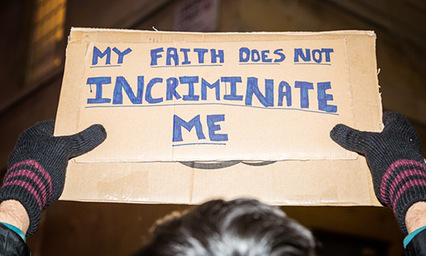

Caption:  British Muslims campaign outside the BBC headquarters in London against negative media portrayals of Muslims
Misinformation (Ground Truth): False
Associated summary:  SUMMARY:
             to understand the world and that we could use our reason to figure out the truth. Therefore, Paine believed that people should use their own reason to understand the world and not blindly follow religious dogma. In The Age of Reason, Paine argues that the Bible is not the word of God but a collection of fables and contradictions. He also attacks the Christian doctrine of the Trinity and the divinity of Jesus.

Paine’s ideas were not popular with many people at the time. He was attacked by many religious leaders and was eventually tried for heresy. But his ideas helped to shape the American Enlightenment and the separation of church and state which is such an important part of American society today.
Model_prediction:  True
Model arguments:  {'model_0': 'Based on the information you provided

In [24]:
incorrect_idx = get_incorrect_idx(result_data4, test_data_annotations)
print(incorrect_idx)
failed_samples(incorrect_idx, result_data4)